# Inference Comparison -- Automated COVID-NIH Deployment

In this Jupyter Notebook, we will show how to build an end-to-end app that is ready to be plugged-in in most of the deployment platform, for example Canon. The inference time with different methods will be benchmarked as well. We take a popular method 
### <span style="color:#3E77CA"> End-to-End Automated Workflow</span>


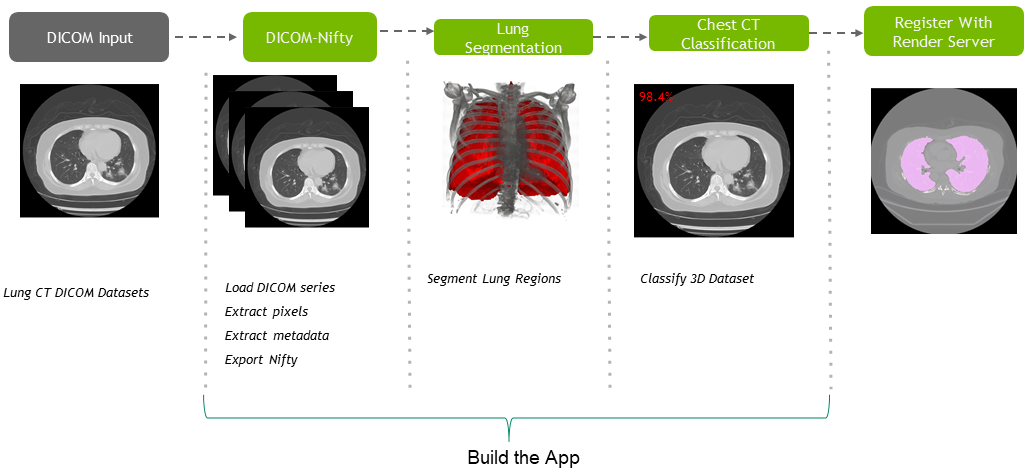

In [17]:
display(Image(filename='covid-19-workflow.png',width=500))

Due to complicated pre/post-processing and libraries dependencies issue, many people start to build a cutomized end-to-end docker for inferencing and use that docker container as an app that is able to be embedded in the platform. 

Main steps to create e-2-e app : 
* Write the DICOM data on file system
* Run the docker mounting the directory
* **DICOM to Nifty conversion**
* **Using model ct lung segmentation to create the mask**
* **Using model classification using the previous mask to classify**
* Format the result



### <span style="color:#3E77CA"> Inference Methods</span>

| Model Format   | Hardware    
| :------------- | :---------- 
| Naive TF (ckpt) from MMAR | CPU (Canon)  
| Naive TF (ckpt) from MMAR | T4  
| TF-TRT | T4  
| TF-TRT TRITON  | T4  

#### <span style="color:#3E77CA">Loading Libraries </span>

In [18]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import average_precision_score
import pandas as pd
import re

#### <span style="color:#3E77CA">Checking the Data </span>

In [2]:
def show_ct_orgn_data(ct_scan_data,num):
    plt.imshow(ct_scan_data.get_fdata()[:,:,num],cmap='gray')
    plt.show()
    
def show_ct_infer_data(ct_scan_data,lung_mask_data,num):
    fig, axs = plt.subplots(1, 2,figsize=(9,7))
    #fig.suptitle('Covid Inference Results')
    axs[0].imshow(ct_scan_data.get_fdata()[:,:,num],cmap='gray')
    axs[1].imshow(lung_mask_data.get_fdata()[:,:,num],cmap='gray')
    #plt.imshow(ct_scan_data.get_fdata()[:,:,num],cmap='gray')
    #plt.show()
    #plt.imshow(lung_mask_data.get_fdata()[:,:,num],cmap='gray')

In [3]:
!ls -l --block-size=M ../data/deployTest.nii.gz
ct_file = "../data/deployTest.nii.gz"
ct_data = nib.load(ct_file)
print("image size:",ct_data.shape)
show_ct_orgn_data(ct_data,100)

-rw-rw-r-- 1 ubuntu ubuntu 78M Sep 17 14:52 ../data/deployTest.nii.gz
image size: (512, 512, 273)


#### <span style="color:#3E77CA"> Build The End-to-End infer Docker (App)</span>

Naive TF from MMAR via Clara Train

In [4]:
!docker build -t ct_seg ./naive_tf/.

Sending build context to Docker daemon  2.941GB
Step 1/15 : FROM nvcr.io/nvidia/clara-train-sdk:v3.0
 ---> edd79e3f8053
Step 2/15 : ENV BASE_NAME="workspace"
 ---> Using cache
 ---> 0f104970f2c6
Step 3/15 : ENV MY_APP_NAME="ct_seg"
 ---> Using cache
 ---> 624f3b8b3be4
Step 4/15 : COPY ./$MY_APP_NAME/commands/* /$BASE_NAME/Canon/naive_tf/ct_seg/commands/
 ---> Using cache
 ---> 9a73b2e6302d
Step 5/15 : COPY ./$MY_APP_NAME/config/* /$BASE_NAME/Canon/naive_tf/ct_seg/config/
 ---> 4725fdc996b1
Step 6/15 : COPY ./$MY_APP_NAME/models/* /$BASE_NAME/Canon/naive_tf/ct_seg/models/
 ---> f91a9961547b
Step 7/15 : COPY ./$MY_APP_NAME/resources/* /$BASE_NAME/Canon/naive_tf/ct_seg/resources/
 ---> e06e1212e66f
Step 8/15 : ENV MY_APP_NAME="ct_class"
 ---> Running in 7e3ed6020168
Removing intermediate container 7e3ed6020168
 ---> f6e4c9305aa3
Step 9/15 : COPY ./$MY_APP_NAME/commands/* /$BASE_NAME/Canon/naive_tf/ct_class/commands/
 ---> 5fc8e8a7e573
Step 10/15 : COPY ./$MY_APP_NAME/config/* /$BASE_NAME/

Inferenced by TRITON

In [ ]:
!docker build -t covid_tf_triton ./tf_triton/.

TF_TRT docker 

In [ ]:
!docker build -t covid_tf_trt ./tf_trt/.

TRT conversion docker (ONNX2trt)

In [10]:
#build from tensorrt docker images 
!docker build -t trtconvert ./trt/.

Sending build context to Docker daemon  1.694GB
Step 1/12 : FROM nvcr.io/nvidia/tensorrt:20.10-py3
 ---> c57678f64506
Step 2/12 : ENV BASE_NAME="workspace"
 ---> Using cache
 ---> 9395e13000e6
Step 3/12 : RUN apt-get update && apt-get install -y --no-install-recommends         libprotobuf-dev         protobuf-compiler
 ---> Using cache
 ---> 174e6f2c5c60
Step 4/12 : RUN cd /workspace/tensorrt/samples/trtexec &&     make &&     cd /workspace
 ---> Using cache
 ---> 3d5f8b6d079d
Step 5/12 : ENV MY_APP_NAME="ct_seg"
 ---> Using cache
 ---> 1a368c2a2b00
Step 6/12 : COPY ./$MY_APP_NAME/models/* /$BASE_NAME/Canon/ct_seg/models/
 ---> Using cache
 ---> c86bdeca10ab
Step 7/12 : ENV MY_APP_NAME="ct_class"
 ---> Using cache
 ---> 2765b0ef69f0
Step 8/12 : COPY ./$MY_APP_NAME/models/* /$BASE_NAME/Canon/ct_class/models/
 ---> Using cache
 ---> 747ba57898d6
Step 9/12 : COPY ./trt_run.sh /$BASE_NAME/Canon/
 ---> Using cache
 ---> d6e528d304f1
Step 10/12 : COPY ./onnx2trt_convert.sh /$BASE_NAME/Canon/

TRT Docker

In [14]:
!docker build -t trtrun ./trt/.

Sending build context to Docker daemon  1.694GB
Step 1/12 : FROM nvcr.io/nvidia/tensorrt:20.10-py3
 ---> c57678f64506
Step 2/12 : ENV BASE_NAME="workspace"
 ---> Using cache
 ---> 9395e13000e6
Step 3/12 : RUN apt-get update && apt-get install -y --no-install-recommends         libprotobuf-dev         protobuf-compiler
 ---> Using cache
 ---> 174e6f2c5c60
Step 4/12 : RUN cd /workspace/tensorrt/samples/trtexec &&     make &&     cd /workspace
 ---> Using cache
 ---> 3d5f8b6d079d
Step 5/12 : ENV MY_APP_NAME="ct_seg"
 ---> Using cache
 ---> 1a368c2a2b00
Step 6/12 : COPY ./$MY_APP_NAME/models/* /$BASE_NAME/Canon/ct_seg/models/
 ---> fffce03944f9
Step 7/12 : ENV MY_APP_NAME="ct_class"
 ---> Running in 59f4a349c482
Removing intermediate container 59f4a349c482
 ---> 17810c2f599f
Step 8/12 : COPY ./$MY_APP_NAME/models/* /$BASE_NAME/Canon/ct_class/models/
 ---> ad326045fe5e
Step 9/12 : COPY ./trt_run.sh /$BASE_NAME/Canon/
 ---> 38647b3f6294
Step 10/12 : COPY ./onnx2trt_convert.sh /$BASE_NAME/Can

#### <span style="color:#3E77CA">Inference on Naive TF </span>

Start to run the end-to-end inference on naive tf checkpoint

In [112]:
!time bash ./naive_tf/docker_run.sh | tee ./naive_tf/outputs.txt

start inference on Segmentation
MMAR_ROOT set to /workspace/Canon/naive_tf/ct_seg/commands/..
2020-11-13 20:36:46.484216: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[7312,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 891b47edf3c0

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
Using TensorFlow backend.
2020-11-13 20:36:49,093 - nvmidl.utils.train_conf - INFO - Automatic Mixed Precision status: Disabled
Previously evaluated: 0 ; To be evaluated: 1
2020-11-13 20:36:49.095257: I tensorflow/stream_executor/platform/de

Quickly Check the output results and inferenceing time 

Empty DataFrame
Columns: [/workspace/Canon/data/deployTest.nii.gz, 0.99846077, 0.0015391934]
Index: []

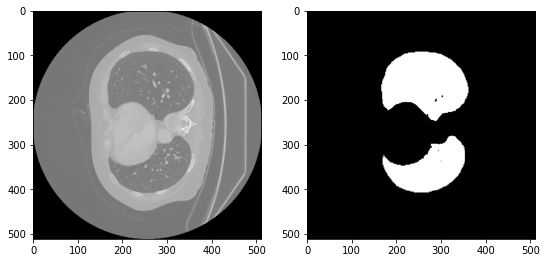

In [47]:
mask_file = "./naive_tf/ct_seg/eval/deployTest/deployTest_model.nii.gz"
mask_result = nib.load(mask_file)
show_ct_infer_data(ct_data,mask_result,100)
classification_result= "./naive_tf/ct_class/eval/preds_model.csv"
pd.read_csv(classification_result)

In [105]:
!cat ./naive_tf/outputs.txt | grep -i "pre-process" 

Batch 1 / 1: 35.98s; pre-process: 8.55s; infer: 18.09s; post-process: 9.34s
Batch 1 / 1: 14.18s; pre-process: 7.38s; infer: 6.33s; post-process: 0.47s


#### <span style="color:#3E77CA">Inference on TF-TRT </span>

In [4]:
!time bash ./tf_trt/docker_run.sh | tee ./tf_trt/outputs.txt

\n start inference on Segmentation...
MMAR_ROOT set to /workspace/Canon/tf_trt/ct_seg/commands/..
2020-11-17 17:52:28.049455: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[30292,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 58d1c4cbc88e

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
Using TensorFlow backend.
2020-11-17 17:52:30,663 - nvmidl.utils.train_conf - INFO - Automatic Mixed Precision status: Disabled
Previously evaluated: 0 ; To be evaluated: 1
2020-11-17 17:52:33.463113: I tensorflow/core/platform/profile_

Check Inference Results

In [65]:
classification_result= "./tf_trt/ct_class/eval/preds_model.csv"
pd.read_csv(classification_result)

Empty DataFrame
Columns: [/workspace/Canon/data/deployTest.nii.gz, 0.99846077, 0.0015391934]
Index: []

Check Inference Time

In [103]:
!cat ./tf_trt/outputs.txt | grep -i "pre-process"

Batch 1 / 1: 34.95s; pre-process: 8.45s; infer: 17.37s; post-process: 9.13s
Batch 1 / 1: 12.83s; pre-process: 7.65s; infer: 5.17s; post-process: 0.00s




#### <span style="color:#3E77CA">Inference on TRITON </span>
Running the two models: Segmentation and Classification using TRITON. Connecting the triton to run segmentation tf-trt first, then saved the output mask results. Inferring classification tf-trt by connecting to triton again. 

In [4]:
%cd tf_triton
%pwd
!time bash infer_whole.sh | tee output_triton.txt
%cd ..

/home/ubuntu/Canon/NIH_covid/tf_triton
start inference on Segmentation...
Error response from daemon: network with name container-demo already exists
315f77b81f69d73478f881f223c947fda96be258cfdd29a54fa9db4d1b0e4994
nvidia-docker run --name trtis --network container-demo -d --rm --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 -p 8000:8000 -v /home/ubuntu/Canon/NIH_covid/tf_triton/models/segmentation_ct_lung_v1:/models/segmentation_ct_lung_v1 nvcr.io/nvidia/tensorrtserver:19.08-py3 trtserver --model-store=/models
Wait until TRTIS 172.27.0.2 is ready...........done
W1113 13:51:26.090953 140540705425216 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:101: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

W1113 13:51:26.091221 140540705425216 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:135: The name tf.train.Optimizer is deprecated.

Check Inference Results

In [92]:
classification_result= "./tf_triton/output/preds_model.csv"
pd.read_csv(classification_result)

0  0.9985804 non-COVID
0  1    0.00142     COVID

Check Inference Time

In [101]:
!cat ./tf_triton/output_triton.txt | grep -i "Batch "
!cat ./tf_triton/output_triton.txt | grep -i "Pre-process Elapsed Time (ms)" 
!cat ./tf_triton/output_triton.txt | grep -i "Post-process and Write Elapsed Time (ms)" 
!cat ./tf_triton/output_triton.txt | grep -i "AI-base_inference Inference Elapsed Time (ms)" 

Batch 1 / 1: 9.40s; pre-process: 5.35s; infer: 4.05s; post-process: 0.00s
[PERF] AI-base_inference Pre-process Elapsed Time (ms): 5626
[PERF] AI-base_inference Post-process and Write Elapsed Time (ms): 3154
[PERF] AI-base_inference Inference Elapsed Time (ms): 17357


#### <span style="color:#3E77CA"> Inference on TRT </span>
Convert the model to trt by converting to onnx model (tf2onnx) first and then onnx to trt (onnx2trt).

In [13]:
# Convert the model to TRT  from ONNX (ONNX2trt)
!bash ./trt/docker_convert_run.sh

convert onnx2trt for segmentation models
&&&& RUNNING TensorRT.trtexec # trtexec --onnx=/workspace/Canon/ct_seg/models/model.onnx --shapes=NV_MODEL_INPUT:0:1x1x320x320x64 --explicitBatch --workspace=3000 --saveEngine=/workspace/Canon/ct_seg/models/model.plan
[12/07/2020-05:27:32] [I] === Model Options ===
[12/07/2020-05:27:32] [I] Format: ONNX
[12/07/2020-05:27:32] [I] Model: /workspace/Canon/ct_seg/models/model.onnx
[12/07/2020-05:27:32] [I] Output:
[12/07/2020-05:27:32] [I] === Build Options ===
[12/07/2020-05:27:32] [I] Max batch: explicit
[12/07/2020-05:27:32] [I] Workspace: 3000 MiB
[12/07/2020-05:27:32] [I] minTiming: 1
[12/07/2020-05:27:32] [I] avgTiming: 8
[12/07/2020-05:27:32] [I] Precision: FP32
[12/07/2020-05:27:32] [I] Calibration: 
[12/07/2020-05:27:32] [I] Refit: Disabled
[12/07/2020-05:27:32] [I] Safe mode: Disabled
[12/07/2020-05:27:32] [I] Save engine: /workspace/Canon/ct_seg/models/model.plan
[12/07/2020-05:27:32] [I] Load engine: 
[12/07/2020-05:27:32] [I] Builder Ca

In [43]:
# check different model format sizes
!ls -l --block-size=M ./trt/ct_class/models

total 371M
-rw-rw-r-- 1 ubuntu ubuntu   1M Nov 17 20:27 checkpoint
-rw-rw-r-- 1 ubuntu ubuntu 130M Nov 17 20:27 model.ckpt.data-00000-of-00001
-rw-rw-r-- 1 ubuntu ubuntu   1M Nov 17 20:27 model.ckpt.index
-rw-rw-r-- 1 ubuntu ubuntu  60M Nov 17 20:27 model.ckpt.meta
-rw-r--r-- 1 root   root    51M Dec  5 04:18 model.engine
-rw-rw-r-- 1 ubuntu ubuntu  44M Nov 17 20:27 model.fzn.pb
-rw-rw-r-- 1 ubuntu ubuntu  44M Dec  2 17:14 model.onnx
-rw-rw-r-- 1 ubuntu ubuntu  44M Nov 17 20:27 model.trt.pb


In [48]:
!ls -l --block-size=M ./trt/ct_seg/models

total 1183M
-rw-rw-r-- 1 ubuntu ubuntu   1M Nov 17 20:27 checkpoint
-rw-rw-r-- 1 ubuntu ubuntu 311M Nov 17 20:27 model.ckpt.data-00000-of-00001
-rw-rw-r-- 1 ubuntu ubuntu   1M Nov 17 20:27 model.ckpt.index
-rw-rw-r-- 1 ubuntu ubuntu 226M Nov 17 20:27 model.ckpt.meta
-rw-r--r-- 1 root   root   111M Dec  5 03:49 model.engine
-rw-rw-r-- 1 ubuntu ubuntu 105M Nov 17 20:27 model.fzn.pb
-rw-rw-r-- 1 ubuntu ubuntu 105M Dec  2 17:08 model.onnx
-rw-r--r-- 1 root   root   111M Dec  3 05:32 model.trt
-rw-r--r-- 1 root   root   111M Dec  3 05:25 model.trt.engine
-rw-rw-r-- 1 ubuntu ubuntu 105M Nov 17 20:27 model.trt.pb


Start TensorRT Inference (Output Inference time as well as Engine Loading time )

In [22]:
#start trt inference
!bash ./trt/docker_trt_run.sh | tee ./trt/output_trt.txt

run trt for segmentation models
&&&& RUNNING TensorRT.trtexec # trtexec --loadEngine=/workspace/Canon/ct_seg/models/model.engine
[12/07/2020-06:01:18] [I] === Model Options ===
[12/07/2020-06:01:18] [I] Format: *
[12/07/2020-06:01:18] [I] Model: 
[12/07/2020-06:01:18] [I] Output:
[12/07/2020-06:01:18] [I] === Build Options ===
[12/07/2020-06:01:18] [I] Max batch: 1
[12/07/2020-06:01:18] [I] Workspace: 16 MiB
[12/07/2020-06:01:18] [I] minTiming: 1
[12/07/2020-06:01:18] [I] avgTiming: 8
[12/07/2020-06:01:18] [I] Precision: FP32
[12/07/2020-06:01:18] [I] Calibration: 
[12/07/2020-06:01:18] [I] Refit: Disabled
[12/07/2020-06:01:18] [I] Safe mode: Disabled
[12/07/2020-06:01:18] [I] Save engine: 
[12/07/2020-06:01:18] [I] Load engine: /workspace/Canon/ct_seg/models/model.engine
[12/07/2020-06:01:18] [I] Builder Cache: Enabled
[12/07/2020-06:01:18] [I] NVTX verbosity: 0
[12/07/2020-06:01:18] [I] Tactic sources: Using default tactic sources
[12/07/2020-06:01:18] [I] Input(s)s format: fp32:CHW


#### <span style="color:#3E77CA"> End-to-End Inference Time Comparison </span>
Extracting all the inferencing time from different methods and compare them together

Model Size 


| Model Format   | Segmentation | Classficiation   
| :------------- | :----------  | :----------
| Naive TF (ckpt) from MMAR | 310.6 MB | 129 MB (FP32)
| TF-TRT | 104.4MB | 43.6 MB (FP32)
| ONNX | 104.6MB | 43.7 MB (INT64)
| TRT | 110.7MB | 50.4 MB (INT32)

End-2-End Inference Time in Second

| Infer Config | pre-process   | Ai-Infer | post-process 
| :------------- | :----------  | :---------- | :------------- 
|TF Segmentation|8.55|18.09|9.34
|TF-TRT Segmentation|8.45|17.37|9.13
|TRITON Segmentation|5.626|17.357|3.154
|TF classification|7.38|6.33|0.47
|TF-TRT classification|7.65|5.17|0.00
|TRITON classification|5.35|4.05|0.00

AI Inference Time (Remove Pre/Post Processing)

| Infer Config | Load Engine/model | Ai-Infer | End-to-End
| :------------- | :----------  | :---------- | :---------- 
|TF classification|1.1|2.6|3.7
|TF-TRT classification|1.2|2.1|3.2
|TRT classification| 17.2|1.25 |18.47
|TF Segmentation|1.77|45|46.7
|TF-TRT Segmentation|1.8|35.8|37.7
|TRT Segmentation|18|17.3|35.3

### <span style="color:#3E77CA">II Using Clara Deploy </span>

We can use Clara Deploy Platform to run end-to-end Covid-NIH pipelines. As the app or pipeline is already avaialbe in clara deploy platform as well as ngc, we simply create the pipelines and run the same example input images. Note that the inferencing time, pre/post-process time will be monitored in clara console. Let's take a look

### <span style="color:#3E77CA"> Build Pipeline and Jobs</span>

In [88]:
!clara list pipelines

NAME                ID
COVID-19-pipeline   a35a48b42dcb4d799365e9726365d363


In [89]:
!clara create jobs -n covid-19-e2d -p a35a48b42dcb4d799365e9726365d363 -f /home/ubuntu/.clara/pipelines/clara_ai_covid19_pipeline/input/LIDC-IDRI-0029_tcia_dcm

JOB_ID: de271cea4441413f9cbca40bdc5ad515
PAYLOAD_ID: 61135ba6c5d34e6f8d448145c1169c8c
Payload uploaded successfully.


In [90]:
!clara start job -j de271cea4441413f9cbca40bdc5ad515

Job Start request submitted successfully with JOB_STATUS_HEALTHY


In [94]:
!kubectl get pod

NAME                                                   READY   STATUS    RESTARTS   AGE
clara-clara-platformapiserver-546c777f68-xqffk         1/1     Running   0          104m
clara-console-7d84577799-5n6mg                         2/2     Running   0          17m
clara-console-mongodb-85f8bd5f95-vfspw                 1/1     Running   0          17m
clara-dicom-adapter-654bc8ffcd-5ggs2                   1/1     Running   0          91m
clara-monitor-server-fluentd-elasticsearch-wgr7q       1/1     Running   0          62m
clara-monitor-server-grafana-5f874b974d-4zr7m          1/1     Running   0          62m
clara-monitor-server-monitor-server-79c8c59fb6-64b2h   1/1     Running   0          62m
clara-pipesvc-fd7219e9-trtis-7f94db6bb5-dgzz5          1/1     Running   0          30s
clara-render-server-clara-renderer-677f4977b4-9hk6w    3/3     Running   0          79m
clara-resultsservice-75c9b9869d-ft66g                  1/1     Running   0          104m
clara-ui-6f89b97df8-7kjmx     

### <span style="color:#3E77CA"> Problem Loading ONNX and TRT Model </span>

When replacing the model.graphdef with model.onnx or model.trt.engine, the clara <span style="color:red">failed the load these models.</span>  The reason is not due to TRITON/TRT version issues. The current Clara Deploy only support V1 TRITON API 

### <span style="color:#3E77CA"> TRITON Version </span>



In [20]:
display(Image(filename='Triton_version.PNG',width=100))

Full details https://docs.nvidia.com/deeplearning/triton-inference-server/release-notes/rel_20-12.html#rel_20-12

The TRT conversion only works on TensorRT 7.2.1 and above. 

Current Clara deploy is V1 TRITON API with the latest version 20.07

In [1]:
!sed -n '38,42p' ~/.clara/pipelines/clara_ai_covid19_pipeline/COVID-19-pipeline.yaml  

  - name: triton
  # Triton Inference Server, required by this AI application.
    container:
      image: nvcr.io/nvidia/tritonserver
      tag: 20.07-v1-py3
